In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import timeit
import seaborn as sns
from pylab import rcParams

pd.set_option('display.max_columns', 500) # to display all the columns
sns.set(style='darkgrid', palette='dark', font_scale=2)
rcParams['figure.figsize'] = 10, 6

In [308]:
# to display plots inline

%matplotlib inline 

In [309]:
#Importing data

try:
    df = pd.read_csv('breastCancer_New.csv')
except Exception as e:
    print(e)
    gc.collect()

In [310]:
#Lookigng into the data
df.head(5)

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [311]:
# Checking the dataframe shape
df.shape

(699, 11)

In [312]:
df['bare_nucleoli'] = df['bare_nucleoli'].replace('?', np.NaN)

In [313]:
#Function to find % of missing values in df 
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 

In [314]:
missing_values_table(df)

,Missing Values,% of Total Values
id,0,0.000000
clump_thickness,0,0.000000
size_uniformity,0,0.000000
shape_uniformity,0,0.000000
marginal_adhesion,0,0.000000
epithelial_size,0,0.000000
bare_nucleoli,16,2.288984
bland_chromatin,0,0.000000
normal_nucleoli,0,0.000000
mitoses,0,0.000000


In [315]:
# Replacing the Nan Values with 0 and converting it to int dtype
df.bare_nucleoli.fillna(0,inplace=True)
df.bare_nucleoli = df.bare_nucleoli.astype(int)

In [316]:
# dropping the id column from df
columns = ['id']
df.drop(columns, inplace=True, axis=1)

In [317]:
df.head(2)

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2


2    458
4    241
Name: class, dtype: int64


Text(0.5,1,'Target Value Counts')

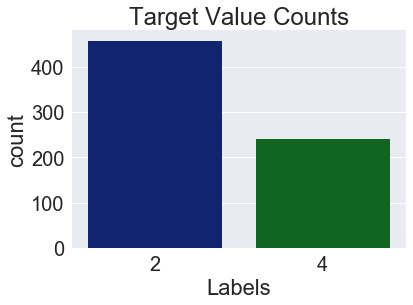

In [318]:
print(df['class'].value_counts())
sns.countplot(df['class'])
plt.xlabel('Labels')
plt.title('Target Value Counts')

In [319]:
# mapping 2 , 4 values to 0 , 1 classes
values = {2: 0, 4: 1}
df['class'] = df['class'].map(values) 

In [320]:
df['class'].value_counts()

0    458
1    241
Name: class, dtype: int64

In [321]:
# Separating Target Variable
y = df['class'].copy()
X = df.drop(labels = ['class'],axis = 1)

In [322]:
#Looking into the shape of features & target
y.shape , X.shape

((699,), (699, 9))

### From the above shown analysis we can see that there is class imbalance problem in the data , below using SMOTE we are solving the class imbalance problem.

In [323]:
#Minority Resampling - SMOTE

from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
sm = SMOTE()
X , y = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y)))

X = pd.DataFrame(X)

Original dataset shape Counter({0: 458, 1: 241})
Resampled dataset shape Counter({0: 458, 1: 458})


In [324]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [325]:
#Looking into the shape of features & target after split
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((732, 9), (732,), (184, 9), (184,))

In [326]:
# Importing the SVM classfier 
from sklearn.svm import SVC

In [327]:
# Function to plaot confusion matrix
def plot_conf_matrix (confusion_matrix):
    class_names = [0,1]
    fontsize=14
    df_conf_matrix = pd.DataFrame(
            confusion_matrix, index=class_names, columns=class_names, 
        )
    fig = plt.figure()
    heatmap = sns.heatmap(df_conf_matrix, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [328]:
# function to plot ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def plot_roc_curve(roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [329]:
X_train.shape, X_test.shape

((732, 9), (184, 9))

# 1. SVM with Linear Kernel 

In [330]:
start_time = timeit.default_timer()

# Creating the /linear classifier

svclassifier_linear = SVC(kernel='linear' , class_weight = 'balanced' , verbose = True)  
svclassifier_linear.fit(X_train, y_train)

svclassifier_linear_time = timeit.default_timer() - start_time

[LibSVM]

In [331]:
# Making Predictions
y_pred_linear = svclassifier_linear.predict(X_test)

In [332]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_linear)
acc_score

0.9782608695652174

In [333]:
print("Precision:",metrics.precision_score(y_test, y_pred_linear))


print("Recall:",metrics.recall_score(y_test, y_pred_linear))

Precision: 0.9888888888888889
Recall: 0.967391304347826


In [334]:
from sklearn.metrics import confusion_matrix
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear, labels=None, sample_weight=None)

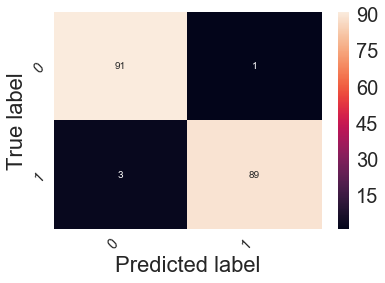

In [335]:
plot_conf_matrix(conf_matrix_linear)

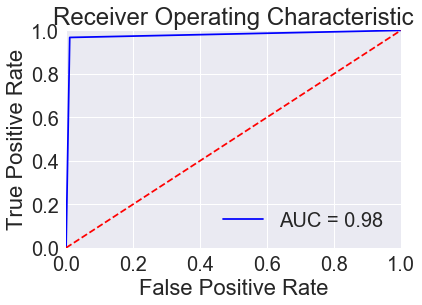

In [336]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_linear)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 2. SVM with Sigmoid Kernel 

In [337]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

In [338]:
X_train_std = scalar.fit_transform(X_train)
X_test_std = scalar.transform(X_test)

C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [339]:
start_time = timeit.default_timer()
# Creating the Sigmoid classifier

svclassifier_sigmoid = SVC(kernel='sigmoid', verbose = True )  
svclassifier_sigmoid.fit(X_train_std, y_train)

svclassifier_sigmoid_time = timeit.default_timer() - start_time

[LibSVM]

In [340]:
# Making Predictions
y_pred_sigmoid = svclassifier_sigmoid.predict(X_test_std)

In [341]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_sigmoid)
acc_score

0.9619565217391305

In [342]:
from sklearn.metrics import classification_report, confusion_matrix  
print(classification_report(y_test, y_pred_sigmoid)) 

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        92
           1       0.96      0.97      0.96        92

   micro avg       0.96      0.96      0.96       184
   macro avg       0.96      0.96      0.96       184
weighted avg       0.96      0.96      0.96       184



In [343]:
from sklearn.metrics import confusion_matrix
conf_matrix_sigmoid = confusion_matrix(y_test, y_pred_sigmoid, labels=None, sample_weight=None)

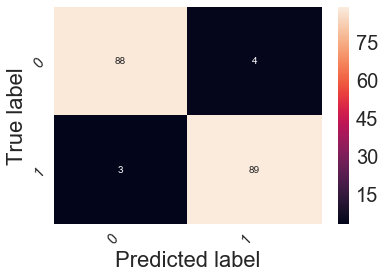

In [344]:
plot_conf_matrix(conf_matrix_sigmoid)

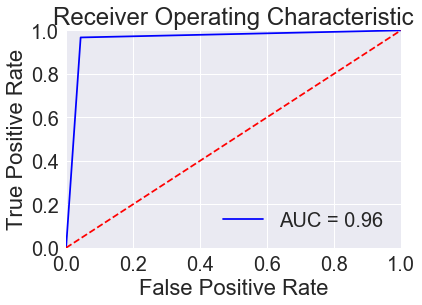

In [345]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_sigmoid)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 3.  SVM with Gaussian/RBF Kernel 

In [346]:
start_time = timeit.default_timer()

# Creating the Gaussian/RBF classifier

svclassifier_rbf = SVC(kernel='rbf' , class_weight = 'balanced' ,verbose = True)  
svclassifier_rbf.fit(X_train_std, y_train)

svclassifier_rbf_time = timeit.default_timer() - start_time

[LibSVM]

In [347]:
# Making Predictions
y_pred_rbf = svclassifier_rbf.predict(X_test_std)

In [348]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_rbf)
acc_score

0.967391304347826

In [349]:
print(classification_report(y_test, y_pred_rbf)) 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        92
           1       0.96      0.98      0.97        92

   micro avg       0.97      0.97      0.97       184
   macro avg       0.97      0.97      0.97       184
weighted avg       0.97      0.97      0.97       184



In [350]:
from sklearn.metrics import confusion_matrix
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf, labels=None, sample_weight=None)

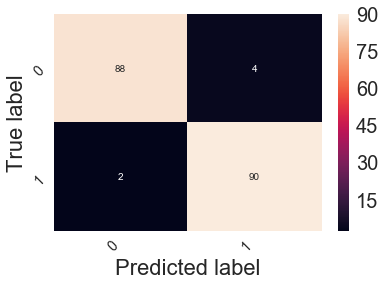

In [351]:
plot_conf_matrix(conf_matrix_rbf)

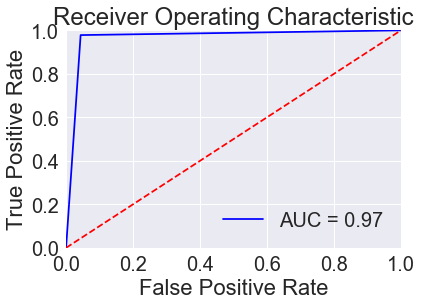

In [352]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_rbf)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 4. SVM with Poly Kernel 

In [353]:
start_time = timeit.default_timer()

# Creating the Sigmoid classifier

svclassifier_poly = SVC(kernel='poly',verbose = True)  
svclassifier_poly.fit(X_train_std, y_train)

svclassifier_poly_time = timeit.default_timer() - start_time

[LibSVM]

In [354]:
# Making Predictions
y_pred_poly = svclassifier_poly.predict(X_test_std)

In [355]:
#from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_poly)
acc_score

0.9782608695652174

In [356]:
print("Precision:",metrics.precision_score(y_test, y_pred_poly))


print("Recall:",metrics.recall_score(y_test, y_pred_poly))

Precision: 0.9680851063829787
Recall: 0.9891304347826086


In [357]:
from sklearn.metrics import confusion_matrix
conf_matrix_poly = confusion_matrix(y_test, y_pred_poly, labels=None, sample_weight=None)

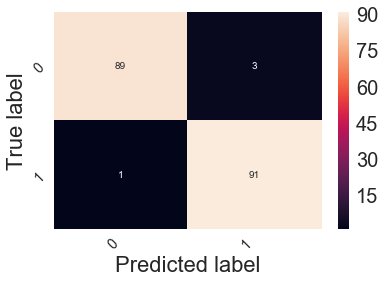

In [358]:
plot_conf_matrix(conf_matrix_poly)

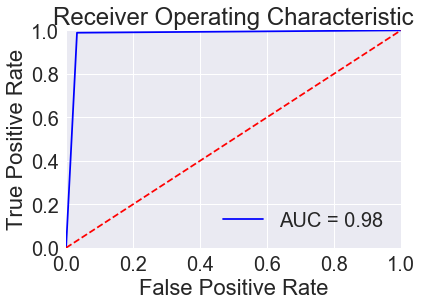

In [359]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_poly)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 5. ANOVA

In [360]:
from sklearn import svm
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# ANOVA SVM-C
# anova filter, take 3 best ranked features
anova_filter = SelectKBest(f_regression, k=3)

start_time = timeit.default_timer()

clf = svm.SVC(kernel='linear')

anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(X_train, y_train)

anova_svm_time = timeit.default_timer() - start_time

y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        92
           1       0.97      0.97      0.97        92

   micro avg       0.97      0.97      0.97       184
   macro avg       0.97      0.97      0.97       184
weighted avg       0.97      0.97      0.97       184



In [361]:
acc_score = accuracy_score(y_test, y_pred)
acc_score

0.967391304347826

In [362]:
print("Precision:",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.967391304347826
Recall: 0.967391304347826


In [363]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

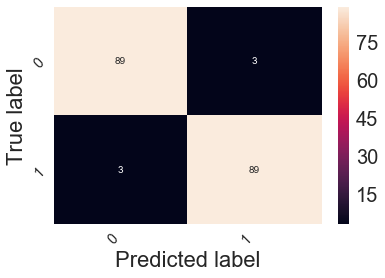

In [364]:
plot_conf_matrix(conf_matrix)

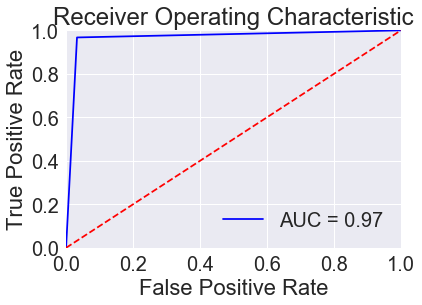

In [365]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 6. Laplacian Kernel

In [366]:
from sklearn.metrics.pairwise import laplacian_kernel
def l_kernel(X, y):
    return laplacian_kernel(X, y)

In [367]:
start_time = timeit.default_timer()

clf_l_kernel = svm.SVC(kernel=l_kernel)
clf_l_kernel.fit(X_train_std, y_train)

clf_l_kernel_time = timeit.default_timer() - start_time

y_pred_l_kernel = clf_l_kernel.predict(X_test_std)

In [368]:
y_pred_l_kernel = clf_l_kernel.predict(X_test_std)

In [369]:
acc_score = accuracy_score(y_test, y_pred_l_kernel)
acc_score

0.9836956521739131

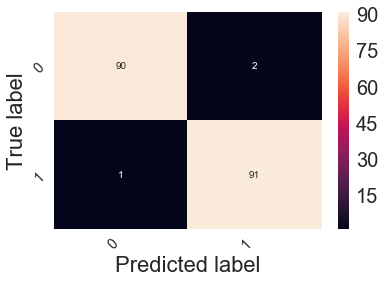

In [370]:
from sklearn.metrics import confusion_matrix
conf_matrix_l_kernel = confusion_matrix(y_test, y_pred_l_kernel, labels=None, sample_weight=None)

plot_conf_matrix(conf_matrix_l_kernel)

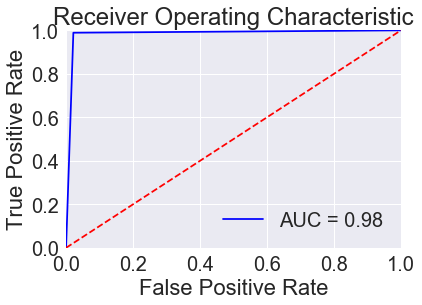

In [371]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_l_kernel)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

In [372]:
print("Precision:",metrics.precision_score(y_test, y_pred_l_kernel))


print("Recall:",metrics.recall_score(y_test, y_pred_l_kernel))

Precision: 0.978494623655914
Recall: 0.9891304347826086


# 1. nu-SVMs - Linear 

In [373]:
from sklearn.svm import NuSVC

In [374]:
start_time = timeit.default_timer()

# Creating the linear classifier

svclassifier_linear = NuSVC(nu= 0.2 , kernel='linear' , class_weight = 'balanced' , verbose = True)  
svclassifier_linear.fit(X_train, y_train)

nu_svclassifier_linear_time = timeit.default_timer() - start_time

[LibSVM]

In [375]:
# Making Predictions
y_pred_linear = svclassifier_linear.predict(X_test)

In [376]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_linear)
acc_score

0.967391304347826

In [377]:
print("Precision:",metrics.precision_score(y_test, y_pred_linear))


print("Recall:",metrics.recall_score(y_test, y_pred_linear))

Precision: 0.9777777777777777
Recall: 0.9565217391304348


In [378]:
from sklearn.metrics import confusion_matrix
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear, labels=None, sample_weight=None)

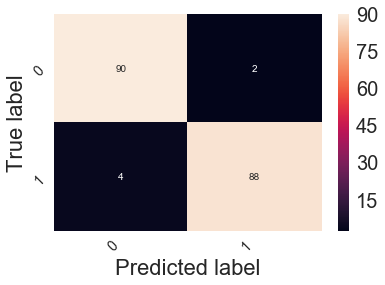

In [379]:
plot_conf_matrix(conf_matrix_linear)

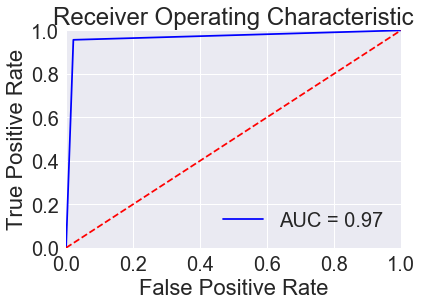

In [380]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_linear)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 2. nu-SVM with Sigmoid Kernel 

In [381]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

In [382]:
X_train_std = scalar.fit_transform(X_train)
X_test_std = scalar.transform(X_test)

C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [383]:
start_time = timeit.default_timer()

# Creating the Sigmoid classifier

svclassifier_sigmoid = NuSVC(nu= 0.2 , kernel='sigmoid', verbose = True )  
svclassifier_sigmoid.fit(X_train_std, y_train)

nu_svclassifier_sigmoid_time = timeit.default_timer() - start_time

[LibSVM]

In [384]:
# Making Predictions
y_pred_sigmoid = svclassifier_sigmoid.predict(X_test_std)

In [385]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_sigmoid)
acc_score

0.967391304347826

In [386]:
from sklearn.metrics import classification_report, confusion_matrix  
print(classification_report(y_test, y_pred_sigmoid)) 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        92
           1       0.97      0.97      0.97        92

   micro avg       0.97      0.97      0.97       184
   macro avg       0.97      0.97      0.97       184
weighted avg       0.97      0.97      0.97       184



In [387]:
from sklearn.metrics import confusion_matrix
conf_matrix_sigmoid = confusion_matrix(y_test, y_pred_sigmoid, labels=None, sample_weight=None)

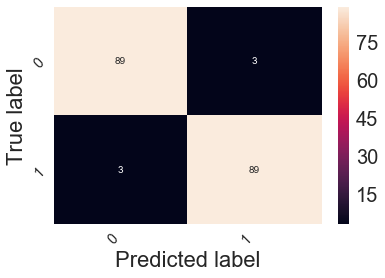

In [388]:
plot_conf_matrix(conf_matrix_sigmoid)

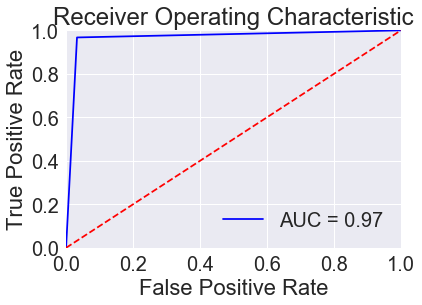

In [389]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_sigmoid)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 3.  nu-SVM with Gaussian/RBF Kernel 

In [390]:
start_time = timeit.default_timer()

# Creating the Gaussian/RBF classifier

svclassifier_rbf = NuSVC(nu= 0.2 , kernel='rbf' , class_weight = 'balanced' ,verbose = True)  
svclassifier_rbf.fit(X_train_std, y_train)

nu_svclassifier_rbf_time = timeit.default_timer() - start_time

[LibSVM]

In [391]:
# Making Predictions
y_pred_rbf = svclassifier_rbf.predict(X_test_std)

In [392]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_rbf)
acc_score

0.967391304347826

In [393]:
print(classification_report(y_test, y_pred_rbf)) 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        92
           1       0.96      0.98      0.97        92

   micro avg       0.97      0.97      0.97       184
   macro avg       0.97      0.97      0.97       184
weighted avg       0.97      0.97      0.97       184



In [394]:
from sklearn.metrics import confusion_matrix
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf, labels=None, sample_weight=None)

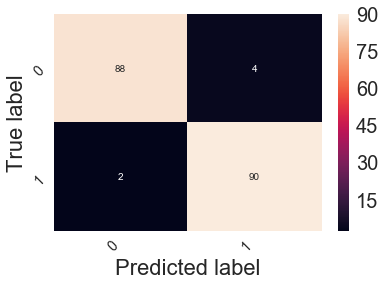

In [395]:
plot_conf_matrix(conf_matrix_rbf)

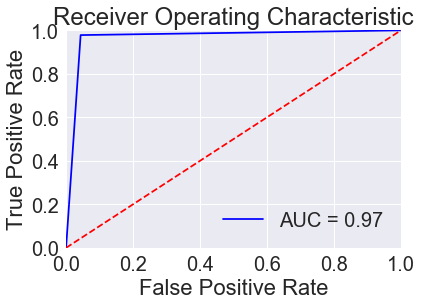

In [396]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_rbf)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 4. nu-SVM with Poly Kernel 

In [397]:
start_time = timeit.default_timer()

# Creating the Sigmoid classifier

svclassifier_poly = NuSVC(nu= 0.2 , kernel='poly',verbose = True)  
svclassifier_poly.fit(X_train_std, y_train)

nu_svclassifier_poly_time = timeit.default_timer() - start_time

[LibSVM]

In [398]:
# Making Predictions
y_pred_poly = svclassifier_poly.predict(X_test_std)

In [399]:
#from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_poly)
acc_score

0.9782608695652174

In [400]:
print("Precision:",metrics.precision_score(y_test, y_pred_poly))


print("Recall:",metrics.recall_score(y_test, y_pred_poly))

Precision: 0.9680851063829787
Recall: 0.9891304347826086


In [401]:
from sklearn.metrics import confusion_matrix
conf_matrix_poly = confusion_matrix(y_test, y_pred_poly, labels=None, sample_weight=None)

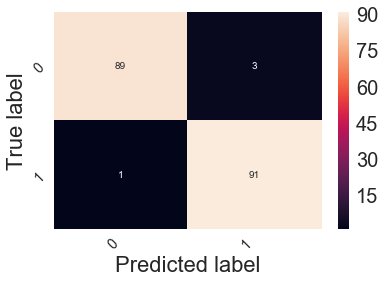

In [402]:
plot_conf_matrix(conf_matrix_poly)

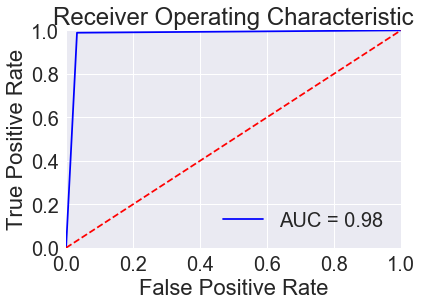

In [403]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_poly)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 5. nu-ANOVA

In [404]:
from sklearn import svm 
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# ANOVA SVM-C
# anova filter, take 3 best ranked features

start_time = timeit.default_timer()

anova_filter = SelectKBest(f_regression, k=3)

clf = NuSVC(nu= 0.2 , kernel='linear')

anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(X_train, y_train)

nu_svclassifier_poly_time = timeit.default_timer() - start_time

y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        92
           1       0.98      0.96      0.97        92

   micro avg       0.97      0.97      0.97       184
   macro avg       0.97      0.97      0.97       184
weighted avg       0.97      0.97      0.97       184



In [405]:
acc_score = accuracy_score(y_test, y_pred)
acc_score

0.967391304347826

In [406]:
print("Precision:",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.9777777777777777
Recall: 0.9565217391304348


In [407]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

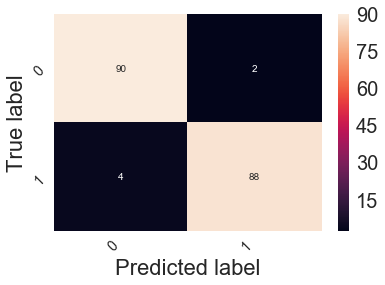

In [408]:
plot_conf_matrix(conf_matrix)

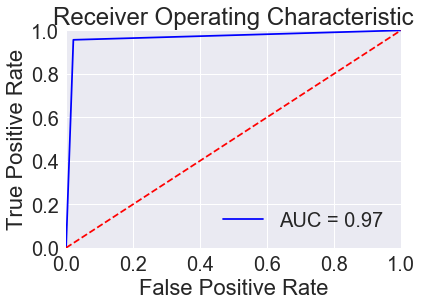

In [409]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 6. nu-Laplacian Kernel

In [410]:
from sklearn.metrics.pairwise import laplacian_kernel
def l_kernel(X, y):
    return laplacian_kernel(X, y)

In [411]:
start_time = timeit.default_timer()

clf_l_kernel = NuSVC(nu= 0.2 ,  kernel=l_kernel)
clf_l_kernel.fit(X_train_std, y_train)

nu_svclassifier_laplacian_time = timeit.default_timer() - start_time

y_pred_l_kernel = clf_l_kernel.predict(X_test_std)

In [412]:
y_pred_l_kernel = clf_l_kernel.predict(X_test_std)

In [413]:
acc_score = accuracy_score(y_test, y_pred_l_kernel)
acc_score

0.9782608695652174

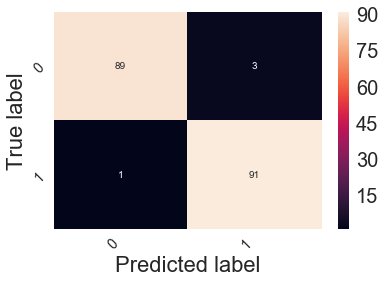

In [414]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_l_kernel, labels=None, sample_weight=None)

plot_conf_matrix(conf_matrix)

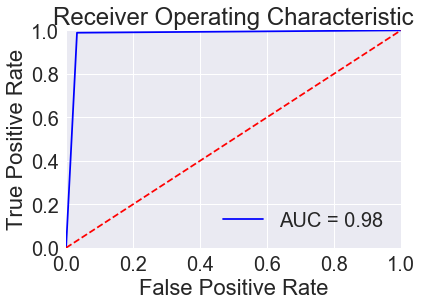

In [415]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_l_kernel)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

In [416]:
print("Precision:",metrics.precision_score(y_test, y_pred_l_kernel))

print("Recall:",metrics.recall_score(y_test, y_pred_l_kernel))

Precision: 0.9680851063829787
Recall: 0.9891304347826086


# 1. c-SVMs - Linear 

In [417]:
start_time = timeit.default_timer()

# Creating the linear classifier

svclassifier_linear = SVC(kernel='linear' , C=1.0 , class_weight = 'balanced' , verbose = True)  
svclassifier_linear.fit(X_train, y_train)

c_svclassifier_linear_time = timeit.default_timer() - start_time

[LibSVM]

In [418]:
# Making Predictions
y_pred_linear = svclassifier_linear.predict(X_test)

In [419]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_linear)
acc_score

0.9782608695652174

In [420]:
print("Precision:",metrics.precision_score(y_test, y_pred_linear))


print("Recall:",metrics.recall_score(y_test, y_pred_linear))

Precision: 0.9888888888888889
Recall: 0.967391304347826


In [421]:
from sklearn.metrics import confusion_matrix
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear, labels=None, sample_weight=None)

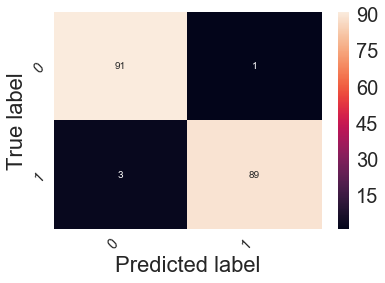

In [422]:
plot_conf_matrix(conf_matrix_linear)

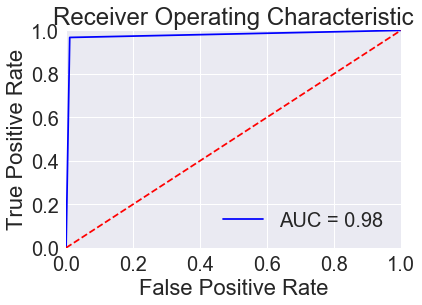

In [423]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_linear)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 2. c-SVM with Sigmoid Kernel 

In [424]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

In [425]:
X_train_std = scalar.fit_transform(X_train)
X_test_std = scalar.transform(X_test)

C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [426]:
start_time = timeit.default_timer()

# Creating the Sigmoid classifier

svclassifier_sigmoid = SVC(C = 1.0 , kernel='sigmoid', verbose = True )  
svclassifier_sigmoid.fit(X_train_std, y_train)

c_svclassifier_sigmoid_time = timeit.default_timer() - start_time

[LibSVM]

In [427]:
# Making Predictions
y_pred_sigmoid = svclassifier_sigmoid.predict(X_test_std)

In [428]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_sigmoid)
acc_score

0.9619565217391305

In [429]:
from sklearn.metrics import classification_report, confusion_matrix  
print(classification_report(y_test, y_pred_sigmoid)) 

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        92
           1       0.96      0.97      0.96        92

   micro avg       0.96      0.96      0.96       184
   macro avg       0.96      0.96      0.96       184
weighted avg       0.96      0.96      0.96       184



In [430]:
from sklearn.metrics import confusion_matrix
conf_matrix_sigmoid = confusion_matrix(y_test, y_pred_sigmoid, labels=None, sample_weight=None)

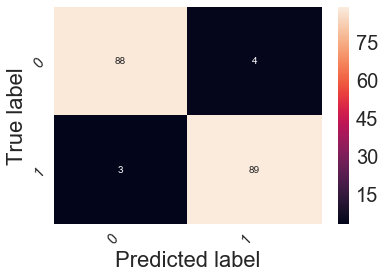

In [431]:
plot_conf_matrix(conf_matrix_sigmoid)

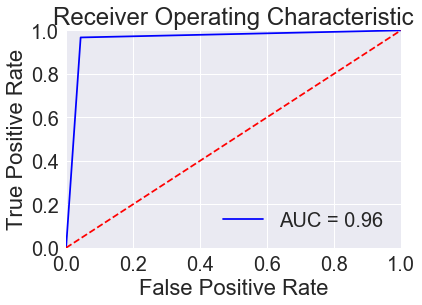

In [432]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_sigmoid)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 3.  c-SVM with Gaussian/RBF Kernel 

In [433]:
start_time = timeit.default_timer()

# Creating the Gaussian/RBF classifier

svclassifier_rbf = SVC(C = 1.0 , kernel='rbf' , class_weight = 'balanced' ,verbose = True)  
svclassifier_rbf.fit(X_train_std, y_train)

c_svclassifier_rbf_time = timeit.default_timer() - start_time

[LibSVM]

In [434]:
# Making Predictions
y_pred_rbf = svclassifier_rbf.predict(X_test_std)

In [435]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_rbf)
acc_score

0.967391304347826

In [436]:
print(classification_report(y_test, y_pred_rbf)) 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        92
           1       0.96      0.98      0.97        92

   micro avg       0.97      0.97      0.97       184
   macro avg       0.97      0.97      0.97       184
weighted avg       0.97      0.97      0.97       184



In [437]:
from sklearn.metrics import confusion_matrix
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf, labels=None, sample_weight=None)

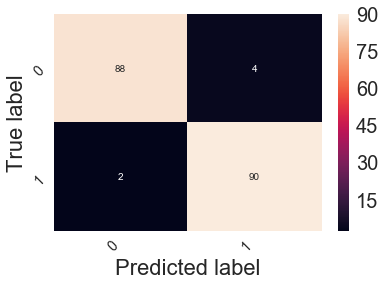

In [438]:
plot_conf_matrix(conf_matrix_rbf)

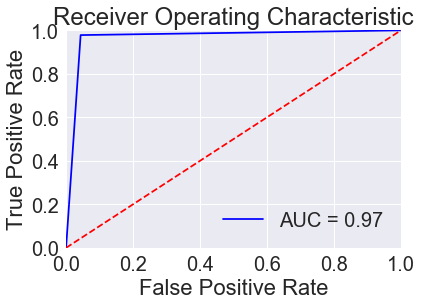

In [439]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_rbf)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 4. c-SVM with Poly Kernel 

In [440]:
start_time = timeit.default_timer()

# Creating the Sigmoid classifier

svclassifier_poly = SVC(C= 1.0 , kernel='poly',verbose = True)  
svclassifier_poly.fit(X_train_std, y_train)

c_svclassifier_poly_time = timeit.default_timer() - start_time

[LibSVM]

In [441]:
# Making Predictions
y_pred_poly = svclassifier_poly.predict(X_test_std)

In [442]:
#from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_test, y_pred_poly)
acc_score

0.9782608695652174

In [443]:
print("Precision:",metrics.precision_score(y_test, y_pred_poly))


print("Recall:",metrics.recall_score(y_test, y_pred_poly))

Precision: 0.9680851063829787
Recall: 0.9891304347826086


In [444]:
from sklearn.metrics import confusion_matrix
conf_matrix_poly = confusion_matrix(y_test, y_pred_poly, labels=None, sample_weight=None)

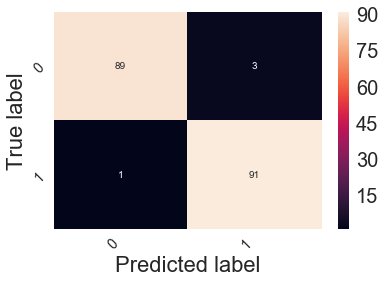

In [445]:
plot_conf_matrix(conf_matrix_poly)

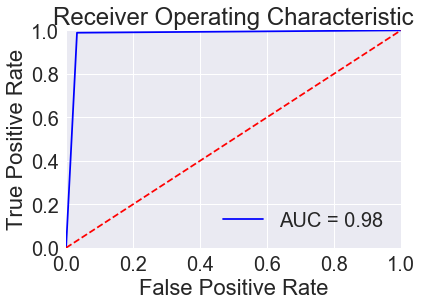

In [446]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_poly)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 5. c-ANOVA

In [447]:
from sklearn import svm 
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# ANOVA SVM-C
# anova filter, take 3 best ranked features
start_time = timeit.default_timer()

anova_filter = SelectKBest(f_regression, k=3)

clf = SVC(C = 1.0 , kernel='linear')

anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(X_train, y_train)

c_svclassifier_annova_time = timeit.default_timer() - start_time

y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        92
           1       0.97      0.97      0.97        92

   micro avg       0.97      0.97      0.97       184
   macro avg       0.97      0.97      0.97       184
weighted avg       0.97      0.97      0.97       184



In [448]:
acc_score = accuracy_score(y_test, y_pred)
acc_score

0.967391304347826

In [449]:
print("Precision:",metrics.precision_score(y_test, y_pred))

print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.967391304347826
Recall: 0.967391304347826


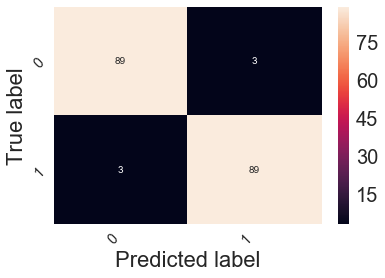

In [450]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

plot_conf_matrix(conf_matrix)

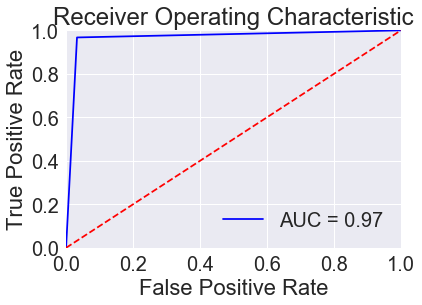

In [451]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

# 6. c-Laplacian Kernel

In [452]:
from sklearn.metrics.pairwise import laplacian_kernel
def l_kernel(X, y):
    return laplacian_kernel(X, y)

In [453]:
start_time = timeit.default_timer()

clf_l_kernel = SVC(C = 1.0 ,  kernel=l_kernel)
clf_l_kernel.fit(X_train_std, y_train)

c_svclassifier_laplacian_time = timeit.default_timer() - start_time

y_pred_l_kernel = clf_l_kernel.predict(X_test_std)

In [454]:
y_pred_l_kernel = clf_l_kernel.predict(X_test_std)

In [455]:
acc_score = accuracy_score(y_test, y_pred_l_kernel)
acc_score

0.9836956521739131

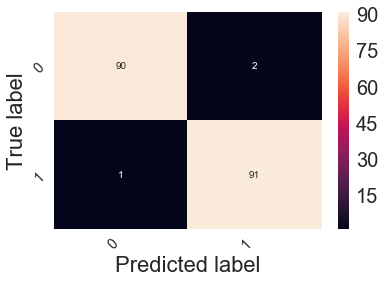

In [456]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_l_kernel, labels=None, sample_weight=None)

plot_conf_matrix(conf_matrix)

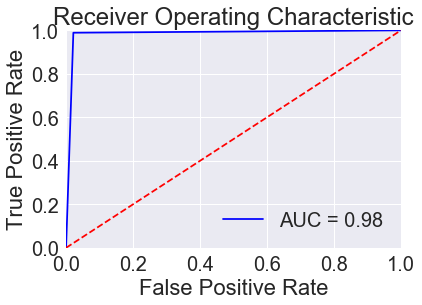

In [457]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_l_kernel)
roc_auc = auc(fpr, tpr)
plot_roc_curve(roc_auc)

In [458]:
print("Precision:",metrics.precision_score(y_test, y_pred_l_kernel))


print("Recall:",metrics.recall_score(y_test, y_pred_l_kernel))

Precision: 0.978494623655914
Recall: 0.9891304347826086


## Analysis of time taken by different SVM Classifier Types

## Time taken by different classifiers with details 

In [459]:
# Creating Dict to capture the time taken by different classifiers 

time = dict( (name,eval(name)) for name in ['c_svclassifier_annova_time','c_svclassifier_laplacian_time','c_svclassifier_linear_time',
'c_svclassifier_poly_time','c_svclassifier_rbf_time','c_svclassifier_sigmoid_time','clf_l_kernel_time',
'svclassifier_linear_time','svclassifier_poly_time','svclassifier_rbf_time','svclassifier_sigmoid_time',
'nu_svclassifier_laplacian_time','nu_svclassifier_linear_time','nu_svclassifier_poly_time','nu_svclassifier_rbf_time',
 'nu_svclassifier_sigmoid_time'] )

In [460]:
# Sorting the list and displaying the time taken in sorted order

sorted(time.items(), key=lambda x: x[1])

[('svclassifier_poly_time', 0.004808032018900121),
 ('c_svclassifier_poly_time', 0.005190148192468769),
 ('c_svclassifier_sigmoid_time', 0.005424628571745416),
 ('svclassifier_sigmoid_time', 0.005826876898936462),
 ('nu_svclassifier_linear_time', 0.00589595781866592),
 ('svclassifier_rbf_time', 0.0061560968256344495),
 ('c_svclassifier_annova_time', 0.006327022758341627),
 ('c_svclassifier_rbf_time', 0.006335312468763732),
 ('c_svclassifier_linear_time', 0.008491821411553246),
 ('svclassifier_linear_time', 0.008905912181944586),
 ('nu_svclassifier_rbf_time', 0.009538693407193932),
 ('nu_svclassifier_sigmoid_time', 0.010735569686403323),
 ('nu_svclassifier_poly_time', 0.011883497199960402),
 ('nu_svclassifier_laplacian_time', 0.018706718336943595),
 ('clf_l_kernel_time', 0.020622036181976),
 ('c_svclassifier_laplacian_time', 0.02269170053932612)]

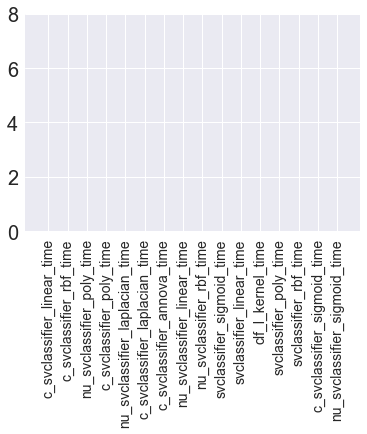

In [461]:
#Visualizing the dataset of time consumed 

names = list(time.keys())
values = list(time.values())

plt.bar(range(len(time)),values,tick_label=names)
plt.xticks(fontsize=14, rotation=90)
plt.ylim(0, 8)
plt.show()

# Ensemble Methods

In [462]:
svVclassifier_linear = NuSVC(nu= 0.2, kernel='linear' , class_weight = 'balanced', probability=True)  
svVclassifier_sigmoid = NuSVC(nu= 0.2, kernel='sigmoid', probability=True)  
svVclassifier_rbf = NuSVC(nu= 0.2, kernel='rbf', class_weight = 'balanced', probability=True)
svVclassifier_poly = NuSVC(nu= 0.2, kernel='poly', probability=True)

anova_filter = SelectKBest(f_regression, k=3)
clf = NuSVC(nu= 0.2 , kernel='linear', probability=True)
svVclassifier_anova = make_pipeline(anova_filter, clf)

svVclassifier_laplace = NuSVC(nu= 0.2, kernel=l_kernel, probability=True)

In [463]:
svclassifier_linear = SVC(kernel='linear' , C=1.0 , class_weight = 'balanced', probability=True)  
svclassifier_sigmoid = SVC(C = 1.0 , kernel='sigmoid', probability=True)  
svclassifier_rbf = SVC(C = 1.0 , kernel='rbf' , class_weight = 'balanced', probability=True)  
svclassifier_poly = SVC(C= 1.0 , kernel='poly', probability=True) 

anova_filter = SelectKBest(f_regression, k=3)
clf = SVC(C = 1.0 , kernel='linear', probability=True)
svclassifier_anova = make_pipeline(anova_filter, clf)

svclassifier_laplace = SVC(C = 1.0 ,  kernel=l_kernel, probability=True)

In [464]:
algorithms = [svVclassifier_linear,svVclassifier_sigmoid,svVclassifier_rbf,svVclassifier_poly,svVclassifier_anova,
              svVclassifier_laplace,svclassifier_linear,svclassifier_sigmoid,svclassifier_rbf,svclassifier_poly,
              svclassifier_anova,svclassifier_laplace]

In [465]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
predictions_prob = np.matlib.zeros((len(y_test), len(algorithms)))
predictions = np.matlib.zeros((len(y_test), len(algorithms)))
training_acc = []
roc_score = []

In [466]:
start_time = timeit.default_timer()
for i,algorithm in enumerate(algorithms):
    clf = algorithm.fit(X_train_std, y_train)
    predictions[:,i] = clf.predict(X_test_std).reshape(X_test_std.shape[0],1)
    predictions_prob[:,i] = clf.predict_proba(X_test_std)[:,1].reshape(X_test_std.shape[0],1)
    #training_acc.append(clf.score(X_train_std,y_train))
    #roc_score.append(roc_auc_score(clf.predict(X_train_std),y_train))
    acc = cross_val_score(clf, X_train_std, y_train, scoring='accuracy', cv=10)
    training_acc.append(acc.mean())
    roc = cross_val_score(clf, X_train_std, y_train, scoring='roc_auc', cv=10)
    roc_score.append(roc.mean())
training_time = timeit.default_timer() - start_time

C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\earmbae\AppData\Local\Continuum\Anaconda2\envs\py35\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid th

In [467]:
method_ensemble = []
acc_ensemble = []
roc_ensemble = []
f1_ensemble = []

# MaxE

In [468]:
start_time = timeit.default_timer()
final_predictions = []
for row_number in range(len(predictions_prob)):
    final_predictions.append(np.max(predictions_prob[row_number, ]))

preds = []
THRESHOLD = 0.7
for i in final_predictions:
    if i > THRESHOLD:
        preds.append(1)
    else:
        preds.append(0)
        
maxe_time = training_time + (timeit.default_timer() - start_time)

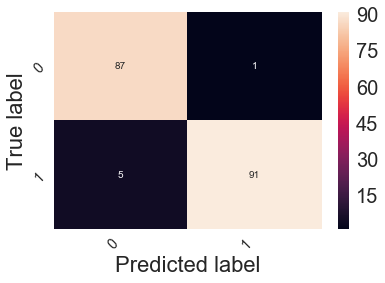

In [469]:
plot_conf_matrix(confusion_matrix(preds,y_test))

In [470]:
method_ensemble.append('MaxE')

In [471]:
acc_ensemble.append(accuracy_score(preds,y_test))

In [472]:
roc_ensemble.append(roc_auc_score(preds,y_test))

In [473]:
f1_ensemble.append(f1_score(preds,y_test))

# MinE

In [474]:
start_time = timeit.default_timer()

final_predictions = []
for row_number in range(len(predictions_prob)):
    final_predictions.append(np.min(predictions_prob[row_number, ]))

preds = []
THRESHOLD = 0.7
for i in final_predictions:
    if i > THRESHOLD:
        preds.append(1)
    else:
        preds.append(0)   
        
mine_time = training_time + (timeit.default_timer() - start_time)

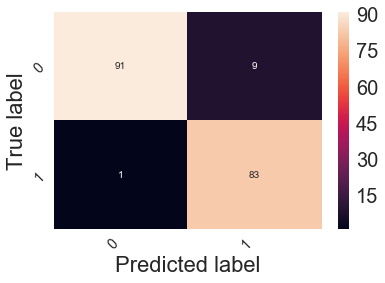

In [475]:
plot_conf_matrix(confusion_matrix(preds,y_test))

In [476]:
method_ensemble.append('MinE')

In [477]:
acc_ensemble.append(accuracy_score(preds,y_test))

In [478]:
roc_ensemble.append(roc_auc_score(preds,y_test))

In [479]:
f1_ensemble.append(f1_score(preds,y_test))

# Majority Voting Ensemble (MVE)

In [480]:
start_time = timeit.default_timer()
preds = []
for row_number in range(len(predictions)):
    (values,counts) = np.unique(np.array(predictions[row_number, ]),return_counts=True)
    ind=np.argmax(counts)
    preds.append(values[ind])

mve_time = training_time + (timeit.default_timer() - start_time)

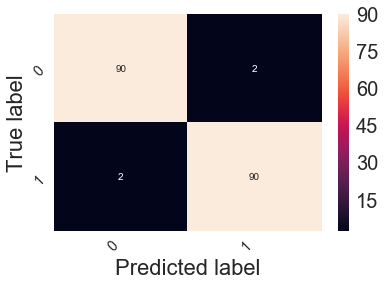

In [481]:
plot_conf_matrix(confusion_matrix(preds,y_test))

In [482]:
method_ensemble.append('MVE')

In [483]:
acc_ensemble.append(accuracy_score(preds,y_test))

In [484]:
roc_ensemble.append(roc_auc_score(preds,y_test))

In [485]:
f1_ensemble.append(f1_score(preds,y_test))

# WAE

In [486]:
start_time = timeit.default_timer()

sum = 0
for acc in training_acc:
    sum = sum + acc

training_acc = training_acc/sum

final_predictions = []
for row_number in range(len(predictions_prob)):
    sum = 0
    for i in range(predictions_prob[0, ].shape[1]):
        sum = sum + (predictions_prob[row_number, ][0,i] * training_acc[i])
    final_predictions.append(sum)

preds = []
THRESHOLD = 0.7
for i in final_predictions:
    if i > THRESHOLD:
        preds.append(1)
    else:
        preds.append(0) 
        
wae_time = training_time + (timeit.default_timer() - start_time)

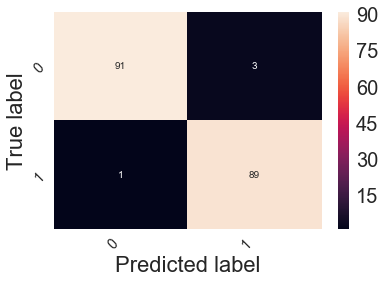

In [487]:
plot_conf_matrix(confusion_matrix(preds,y_test))

In [488]:
method_ensemble.append('WAE')

In [489]:
acc_ensemble.append(accuracy_score(preds,y_test))

In [490]:
roc_ensemble.append(roc_auc_score(preds,y_test))

In [491]:
f1_ensemble.append(f1_score(preds,y_test))

# Bagging Classifier Tree (BCT)

In [492]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [493]:
start_time = timeit.default_timer()
clf_bg = BaggingClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=200)
clf_bg.fit(X_train_std,y_train)

bct_time = timeit.default_timer() - start_time

In [494]:
y_pred = clf_bg.predict(X_test_std)

In [495]:
method_ensemble.append('BCT')

In [496]:
acc_ensemble.append(accuracy_score(y_test, y_pred))

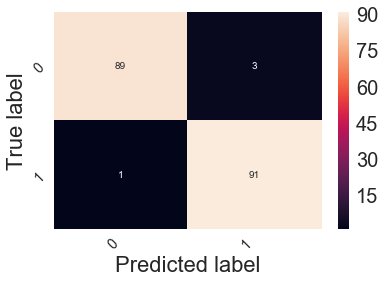

In [497]:
from sklearn.metrics import confusion_matrix
conf_matrix_bct = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

plot_conf_matrix(conf_matrix_bct)

In [498]:
roc_ensemble.append(roc_auc_score(preds,y_test))

In [499]:
f1_ensemble.append(f1_score(preds,y_test))

# Adaboost classifier

In [500]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

start_time = timeit.default_timer()
clf_ad = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
                          n_estimators=300, random_state=1)
clf_ad.fit(X_train_std,y_train)

adaboost_time = timeit.default_timer() - start_time

In [501]:
# Making Predictions
boosting_pred = clf_ad.predict(X_test_std)

In [502]:
method_ensemble.append('Adaboost')

In [503]:
#from sklearn.metrics import accuracy_score
acc_ensemble.append(accuracy_score(y_test, boosting_pred))

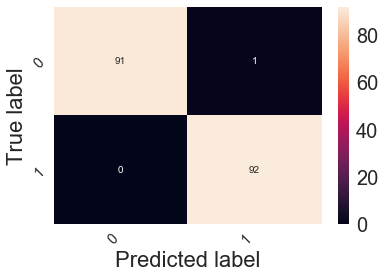

In [504]:
from sklearn.metrics import confusion_matrix
conf_matrix_boosting = confusion_matrix(y_test, boosting_pred, labels=None, sample_weight=None)
plot_conf_matrix(conf_matrix_boosting)

In [505]:
roc_ensemble.append(roc_auc_score(preds,y_test))

In [506]:
f1_ensemble.append(f1_score(preds,y_test))

# WAUCE

In [507]:
start_time = timeit.default_timer()
sum = 0
for score in roc_score:
    sum = sum + score

roc_score = roc_score/sum

final_predictions = []
for row_number in range(len(predictions_prob)):
    sum = 0
    for i in range(predictions_prob[0, ].shape[1]):
        sum = sum + (predictions_prob[row_number, ][0,i] * roc_score[i])
    final_predictions.append(sum)

preds = []
THRESHOLD = 0.7
for i in final_predictions:
    if i > THRESHOLD:
        preds.append(1)
    else:
        preds.append(0) 
        
wauce_time = training_time + (timeit.default_timer() - start_time)

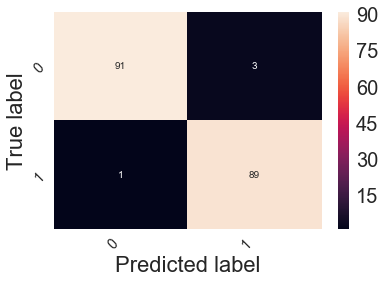

In [508]:
plot_conf_matrix(confusion_matrix(preds,y_test))

In [509]:
method_ensemble.append('WAUCE')

In [510]:
acc_ensemble.append(accuracy_score(preds,y_test))

In [511]:
roc_ensemble.append(roc_auc_score(preds,y_test))

In [512]:
f1_ensemble.append(f1_score(preds,y_test))

In [513]:
# Creating Dict to capture the time taken by different ensemble methods 

time = dict((name,eval(name)) for name in ['maxe_time','mine_time','mve_time','wae_time',
                                           'bct_time','adaboost_time','wauce_time'])

In [514]:
# Sorting the list and displaying the time taken in sorted order

sorted(time.items(), key=lambda x: x[1])

[('bct_time', 0.28875074459392636),
 ('adaboost_time', 0.5315693882312189),
 ('mine_time', 5.653262336569696),
 ('maxe_time', 5.653327864756193),
 ('mve_time', 5.657676409971373),
 ('wauce_time', 5.662461151851403),
 ('wae_time', 5.663524208520357)]

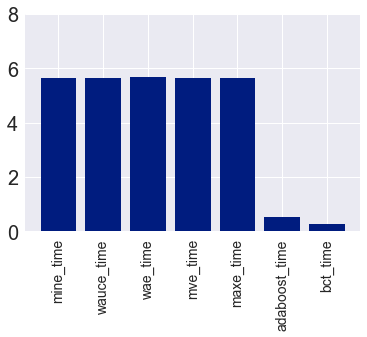

In [515]:
#Visualizing the dataset of time consumed 

names = list(time.keys())
values = list(time.values())

plt.bar(range(len(time)),values,tick_label=names)
plt.xticks(fontsize=14, rotation=90)
plt.ylim(0, 8)
plt.show()

In [298]:
method_ensemble

['MaxE', 'MinE', 'MVE', 'WAE', 'BCT', 'Adaboost', 'WAUCE']

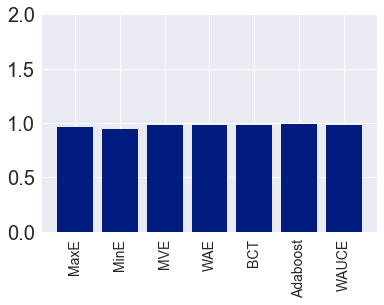

In [521]:
plt.bar(method_ensemble,acc_ensemble,tick_label=method_ensemble)
plt.xticks(fontsize=14, rotation=90)
plt.ylim(0, 2)
plt.show()

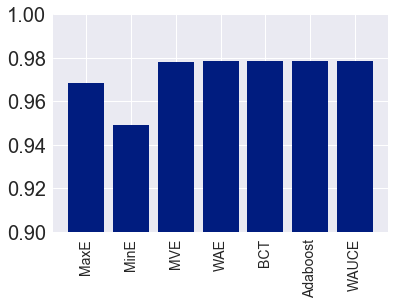

In [522]:
plt.bar(method_ensemble,roc_ensemble,tick_label=method_ensemble)
plt.xticks(fontsize=14, rotation=90)
plt.ylim(0.9, 1)
plt.show()

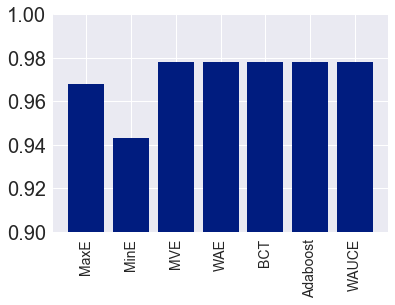

In [523]:
plt.bar(method_ensemble,f1_ensemble,tick_label=method_ensemble)
plt.xticks(fontsize=14, rotation=90)
plt.ylim(0.9, 1)
plt.show()